In [69]:
import pandas as pd

In [70]:
df = pd.read_csv("data/israeli-palestinian-conflict_articles_llama_distill.csv")

In [71]:
# Map source bias to numeric values
bias_mapping = {
    "farLeft": -3, "left": -2, "leanLeft": -1,
    "center": 0, "unknown": 0,
    "leanRight": 1, "right": 2, "farRight": 3
}

df["date_obj"] = pd.to_datetime(df["date"])
df["description"] = df["description"].fillna("")
df["source_name"] = df["source_name"].fillna("")
df["source_bias_num"] = df["source_bias"].map(bias_mapping)

In [72]:
df.columns

Index(['index', 'interest_slug', 'story_id', 'title', 'description', 'date',
       'url', 'lang', 'paywall', 'source_name', 'source_slug', 'source_bias',
       'source_factuality', 'source_originalBias', 'source_storyCount',
       'source_owners', 'source_biasRatings', 'source_lat', 'source_lon',
       'source_place', 'article_title', 'article_description',
       'article_image_url', 'article_text', 'article_date_publish',
       'article_authors', 'llama_bias', 'score', 'llama_distill_bias',
       'score.1', 'date_obj', 'source_bias_num'],
      dtype='object')

In [73]:
df_clean = df[["story_id",
    "title",
    "url",
    "description",
    "date",
    "lang",
    "source_name",
    "source_bias",
    "source_storyCount",
    "article_image_url",
    "llama_distill_bias"]]

# Keep only story_ids with more than 10 articles
df_clean = df_clean.groupby("story_id").filter(lambda x: len(x) > 10)

df_clean

,story_id,title,url,description,date,lang,source_name,source_bias,source_storyCount,article_image_url,llama_distill_bias
0,ad2c7886-e3d1-4630-bbde-d1965f491ef1,Gaza: Six babies have died from cold in two we...,https://www.bbc.com/news/articles/c62k676gk34o,Five newborns and a two-month-old have reporte...,2025-02-25T21:31:42.000Z,en,BBC News,center,912497,https://ichef.bbci.co.uk/news/1024/branded_new...,0
1,ad2c7886-e3d1-4630-bbde-d1965f491ef1,Medics say 6 babies have died from the cold in...,https://www.independent.co.uk/news/gaza-israel...,Palestinian medics say at least six infants ha...,2025-02-25T15:36:46.000Z,en,The Independent,leanLeft,563864,https://static.independent.co.uk/2025/02/25/11...,1
2,ad2c7886-e3d1-4630-bbde-d1965f491ef1,Medics say 6 babies have died from the cold in...,https://www.ctvnews.ca/world/israel-hamas-war/...,At least six infants have died from hypothermi...,2025-02-25T17:06:59.000Z,en,CTV News,center,542419,https://www.ctvnews.ca/resizer/v2/TSNHSZMVGQV3...,2
3,ad2c7886-e3d1-4630-bbde-d1965f491ef1,At least 6 infants dead in Gaza due to cold we...,https://www.cbc.ca/news/world/infants-dead-hyp...,At least six infants have died from cold-relat...,2025-02-25T22:00:34.000Z,en,CBC News,leanLeft,488460,https://i.cbc.ca/1.7467722.1740495952!/fileIma...,1
4,ad2c7886-e3d1-4630-bbde-d1965f491ef1,Medics say 6 babies have died from the cold in...,https://apnews.com/article/israel-palestinians...,Palestinian medics say at least six infants ha...,2025-02-25T16:53:09.000Z,en,Associated Press News,leanLeft,471764,https://dims.apnews.com/dims4/default/9997738/...,1
...,...,...,...,...,...,...,...,...,...,...,...
61432,9e5dbd0c-88e2-4e63-ac58-5599fa824482,Hamas Official Says He Would Not Have Supporte...,https://www.sofx.com/hamas-official-says-he-wo...,Senior Hamas official Moussa Abu Marzouk expre...,2025-02-25T03:19:46.000Z,en,SOFX,unknown,1180,https://www.sofx.com/wp-content/uploads/2025/0...,4
61433,9e5dbd0c-88e2-4e63-ac58-5599fa824482,Jana Beris on October 7 Attack and Its Devasta...,https://www.bnaibrith.org/jana-beris-october-7...,Play Video \n\t\t\t\t\t\t\n\t\t\t\t\t\n\t\t\t\...,2025-02-25T21:30:02.000Z,en,B'nai B'rith International,unknown,140,https://bnaibrith-org-wpom.nyc3.cdn.digitaloce...,3
61434,9e5dbd0c-88e2-4e63-ac58-5599fa824482,Hamas Official Has Regrets: Would Not Have Sup...,https://altnews.org/2025/02/26/hamas-official-...,A senior Hamas official told the New York Time...,2025-02-25T17:04:34.000Z,en,altnews.org,unknown,16045,https://media.breitbart.com/media/2025/02/Hama...,4
61435,9e5dbd0c-88e2-4e63-ac58-5599fa824482,Hamas official says October 7th wouldn't have ...,https://worldisraelnews.com/hamas-official-cla...,Marzouk’s admission of regret does not reflect...,2025-02-24T19:23:36.000Z,en,WIN,right,5801,https://worldisraelnews.com/wp-content/uploads...,4


In [5]:
df_clean.to_csv("data/climate-change_articles_llama_distill_clean.csv", index=False)

## Clustering

In [56]:
import pandas as pd
import numpy as np
from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from scipy.interpolate import interp1d

In [4]:
import pandas as pd
import numpy as np

# Parameters
NUM_TIMESTEPS = 16

# Example values
values = np.array([0.1, 0.2, -0.1, 0.4, 2])  # Sample bias sequence


def dalton_polarization_index(positions):
    positions = np.array(positions)
    mean_val = np.mean(positions)
    
    # Get unique values and their frequencies
    unique_vals, counts = np.unique(positions, return_counts=True)
    proportions = counts / len(positions)
    
    # Vectorized calculation of PI
    squared_diffs = (unique_vals - mean_val) ** 2
    pi = np.sqrt(np.sum(proportions * squared_diffs))
    
    return pi

def accumulated_bins(values, num_bins, func):
    bin_edges = np.linspace(0, len(values), num_bins + 1, dtype=int)
    res = []

    for i in range(1, num_bins + 1):
        idx_end = bin_edges[i]
        subset = values[:idx_end]
        if len(subset) > 1:
            val = func(subset)
        else:
            val = func(values[:1])
        res.append(val)

    return np.array(res)

# Test it
acc_var = accumulated_bins(values, NUM_TIMESTEPS, func=np.var)
print("Accumulated variance per timestep:")
print(np.round(acc_var, 4))


Accumulated variance per timestep:
[0.     0.     0.     0.     0.     0.     0.0025 0.0025 0.0025 0.0156
 0.0156 0.0156 0.0325 0.0325 0.0325 0.5736]


In [ ]:
# Load data
df = pd.read_csv("data/climate-change_articles_llama_distill_clean.csv", parse_dates=["date"])
df = df.dropna(subset=["llama_distill_bias", "source_bias_num"])

# Parameters
NUM_TIMESTEPS = 16

# Process each story
time_series_list = []
story_ids = []

for story_id, group in df.groupby("story_id"):
    group_sorted = group.sort_values("date")
    values = group_sorted["llama_distill_bias"].to_numpy()
    acc_var = accumulated_bins(values, NUM_TIMESTEPS, np.var)
    acc_mean = accumulated_bins(values, NUM_TIMESTEPS, np.mean)
    acc_pol = accumulated_bins(values, NUM_TIMESTEPS, dalton_polarization_index)

    time_series_list.append(np.stack([acc_pol, acc_mean], axis=1))
    story_ids.append(story_id)

In [6]:
time_series_list[:2]

[array([[0.5       , 1.5       ],
        [0.5       , 1.5       ],
        [0.49487166, 1.42857143],
        [0.47140452, 1.33333333],
        [0.44536177, 1.27272727],
        [0.49487166, 1.42857143],
        [0.5       , 1.5       ],
        [0.499307  , 1.47368421],
        [0.49943278, 1.47619048],
        [0.57021205, 1.39130435],
        [0.61658537, 1.34615385],
        [0.60080728, 1.32142857],
        [0.59628479, 1.33333333],
        [0.73605805, 1.39393939],
        [0.83982505, 1.45714286],
        [0.81536491, 1.42105263]]),
 array([[0.        , 2.        ],
        [0.5       , 1.5       ],
        [0.47140452, 1.33333333],
        [0.4330127 , 1.25      ],
        [0.8       , 1.6       ],
        [0.76376262, 1.5       ],
        [0.72843136, 1.57142857],
        [0.68493489, 1.55555556],
        [0.67082039, 1.5       ],
        [0.65555478, 1.54545455],
        [0.64549722, 1.5       ],
        [0.63432394, 1.53846154],
        [0.62678317, 1.5       ],
        [0.7

In [21]:
len(time_series_list)

813

### Elbow

In [9]:
# Convert to numpy array
X = np.array(time_series_list)

In [ ]:
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans

inertias = []
K_range = [2, 5, 10, 20, 50]

for k in K_range:
    print(f"Running k={k}")
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42, n_jobs=-1)
    km.fit(X)
    inertias.append(km.inertia_)

# Plot elbow
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("DTW Cost (Inertia)")
plt.title("Elbow Method for TimeSeriesKMeans (DTW)")
plt.grid(True)
plt.show()


In [15]:
# Use time series clustering
from tslearn.clustering import TimeSeriesKMeans

# Time series clustering
km = TimeSeriesKMeans(n_clusters=15, metric="dtw", random_state=42, n_jobs=-1)
y_km = km.fit_predict(X)

# Add cluster labels to dataframe
df_clusters = pd.DataFrame({
    "story_id": story_ids,
    "cluster": y_km
})

df_clusters.value_counts("cluster")

cluster
3     206
7     110
2      72
11     67
12     63
1      53
5      49
9      43
4      32
0      26
6      25
13     21
10     18
8      15
14     13
Name: count, dtype: int64

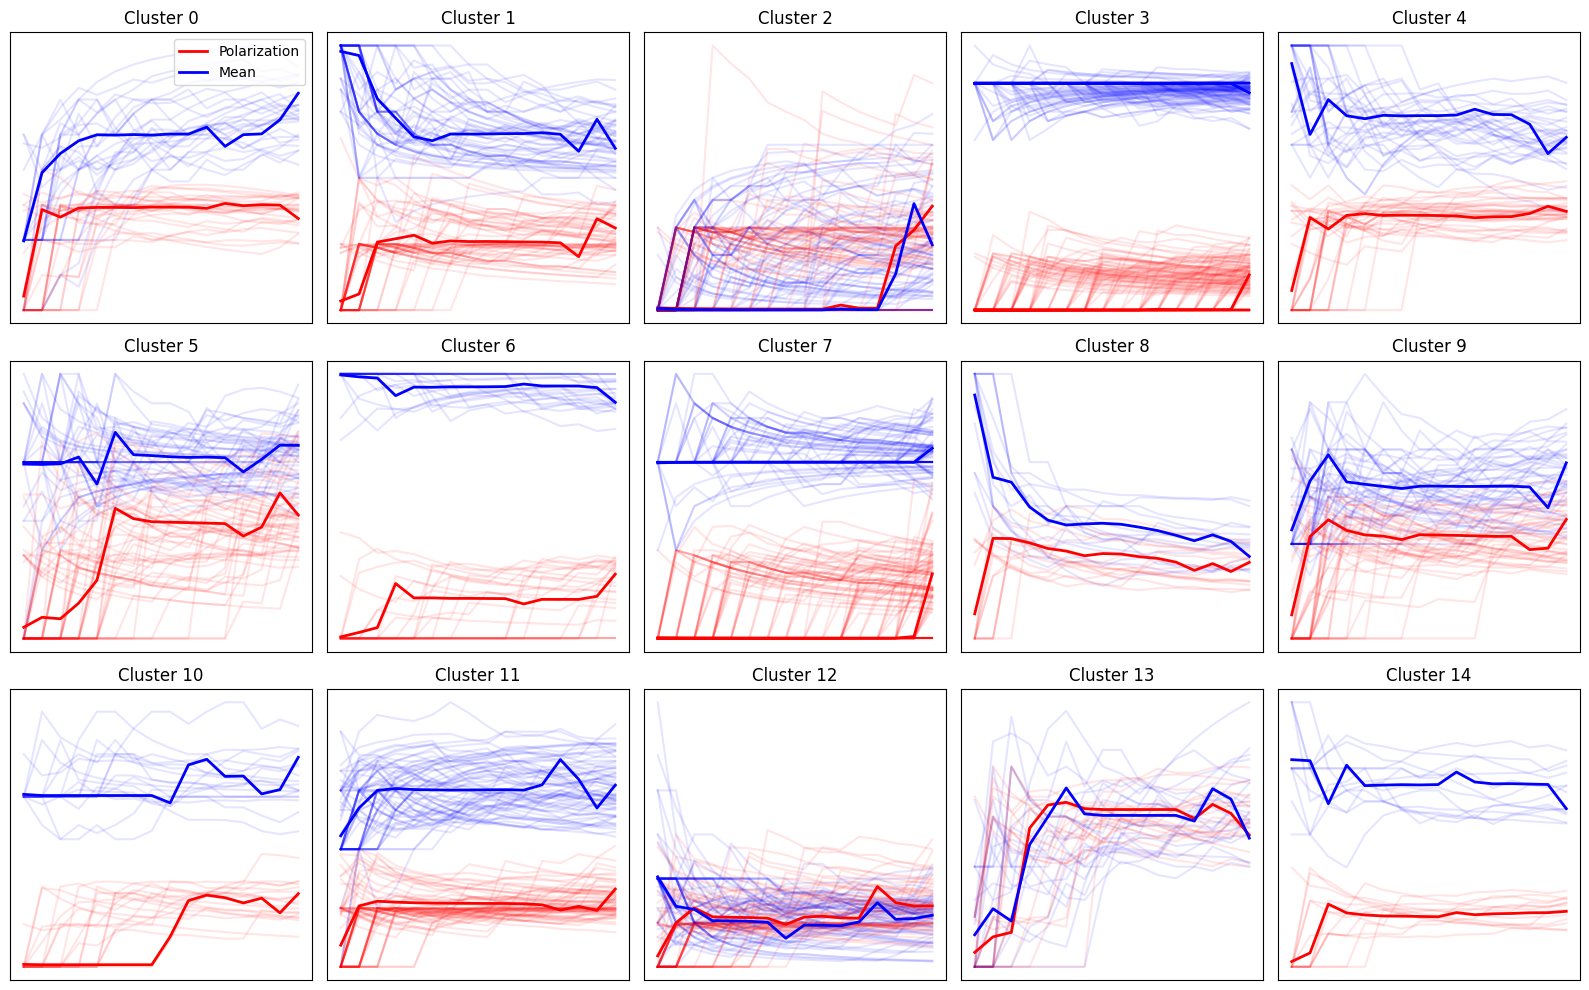

In [17]:
# Visualize clusters
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset

# Convert to time series dataset
X_ts = to_time_series_dataset(X)

colors = ['r', 'b']  # red for variance, blue for mean

plt.figure(figsize=(16, 10))
for i in range(min(15, km.n_clusters)):
    plt.subplot(3, 5, i + 1)
    
    cluster_series = X_ts[y_km == i]
    
    # Plot each dimension separately
    for ts in cluster_series:
        plt.plot(ts[:, 0], color='r', alpha=0.1)  # variance
        plt.plot(ts[:, 1], color='b', alpha=0.1)  # mean
    
    # Plot cluster center
    plt.plot(km.cluster_centers_[i][:, 0], color='r', lw=2, label='Polarization')
    plt.plot(km.cluster_centers_[i][:, 1], color='b', lw=2, label='Mean')

    plt.title(f"Cluster {i}")
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [18]:
# Add cluster labels to original dataframe
df["cluster"] = df["story_id"].map(df_clusters.set_index("story_id")["cluster"])
df.to_csv("data/climate-change_articles_llama_distill_clusters.csv", index=False)

## Just create a new json

In [74]:
import numpy as np

def dalton_polarization_index(positions):
    positions = np.array(positions)
    mean_val = np.mean(positions)
    
    # Get unique values and their frequencies
    unique_vals, counts = np.unique(positions, return_counts=True)
    proportions = counts / len(positions)
    
    # Vectorized calculation of PI
    squared_diffs = (unique_vals - mean_val) ** 2
    pi = np.sqrt(np.sum(proportions * squared_diffs))
    
    return pi

def compute_polarization_series(bias_series, func):
    """
    Computes Dalton Polarization Index for each article in the series.
    """
    bias_series = np.array(bias_series)
    polarization_indices = []
    
    for i in range(1, len(bias_series) + 1):
        current_subset = bias_series[:i]
        pi = func(current_subset)
        polarization_indices.append(pi)
        
    return np.array(polarization_indices)

# Use numpy to get the index of the first step to reach a given value
def first_step_to_value(series, target_value):
    """
    Finds the first index in the series where the value is greater than or equal to the target value.
    Returns None if the target is not reached.
    """
    series = np.array(series)
    mask = series >= target_value

    if not np.any(mask):
        return None

    return int(np.argmax(mask))

In [75]:
# Create a new json, an array of stories

import json

NUM_TIMESTEPS = 16


# Create a list of dictionaries for each story
stories = []
for story_id, group in df.groupby("story_id"):
    group = group.sort_values(["date", "source_storyCount"], ascending=[True, False])

    num_articles = len(group)
    coverage_days = (group["date_obj"].max() - group["date_obj"].min()).days + 1  # add 1 to include both endpoints

    biases = group["llama_distill_bias"].to_numpy() # Exclude the first article
    polarization = compute_polarization_series(biases, dalton_polarization_index) / 2.0
    
    clipped_num_articles = min(num_articles, 300) / 300
    
    first_to_threshold = first_step_to_value(polarization, 0.75)
    above_threshold = 0
    if first_to_threshold is not None:
        above_threshold = (num_articles - first_to_threshold) / num_articles

    surprise_index = 2 * (np.mean(polarization) + above_threshold) * clipped_num_articles
    
    story_data = {
        "story_id": story_id,
        "title": group["title"].values[0],
        "url": group["url"].values[0],
        "description": group["description"].values[0],
        "num_articles": num_articles,
        "polarization": polarization.tolist(),
        "first_to_threshold": first_to_threshold,
        "surprise_index": surprise_index,
    }

    articles = []
    
    for i, row in enumerate(group.itertuples()):
        article = {
            "date": row.date,
            "title": row.title,
            "url": row.url,
            # "description": row.description,
            "lang": row.lang,
            "source_name": row.source_name,
            "source_bias": row.source_bias,
            "source_storyCount": row.source_storyCount,
            "article_image_url": row.article_image_url,
            "bias": row.llama_distill_bias,
        }
        articles.append(article)
    
    story_data["articles"] = articles
    stories.append(story_data)
    
stories = sorted(stories, key=lambda x: x["surprise_index"], reverse=True)

# Save to JSON file
with open("data/israeli-palestinian-conflict.json", "w") as f:
    json.dump(stories, f)

## DF analysis

In [45]:
np.histogram([0, 1, 1, 2, 4], bins=[0, 1, 2, 3, 4, 5])

(array([1, 2, 1, 0, 1]), array([0, 1, 2, 3, 4, 5]))

In [54]:
len(df["story_id"].unique())

6412

In [68]:
# Group the data by source_name and calculate the mean llama_distill_bias
# Produce a dataset with source_name, mean llama_distill_bias, source story count, and source bias
# Only keep sources with more than 10 entries
source_bias_df = df.groupby("source_name").agg(
    mean_bias=("llama_distill_bias", "mean"),
    # The count for each bias -2 to 2
    bias_dist=("llama_distill_bias", lambda x: np.histogram(x, bins=[0, 1, 2, 3, 4, 5])[0].tolist()),
    total_story_count=("source_storyCount", "last"),
    source_bias=("source_bias_num", "first"),
    topic_story_count=("story_id", "count"),
    source_lon=("source_lon", "first"),
    source_lat=("source_lat", "first"),
    source_owners=("source_owners", "first"),
).reset_index()

# Filter sources with more than 10 entries
source_bias_df["mean_bias"] = source_bias_df["mean_bias"] - 2

# Save to CSV
source_bias_df.to_csv("dist/source_bias.csv", index=False)

source_bias_df

,source_name,mean_bias,bias_dist,total_story_count,source_bias,topic_story_count,source_lon,source_lat,source_owners
0,+972 Magazine,-1.600000,"[12, 2, 0, 0, 1]",703,-1,15,NaN,NaN,None
1,- South Asian Daily where south asians meet ...,0.846154,"[0, 3, 2, 2, 6]",1628,0,13,NaN,NaN,None
2,.,2.000000,"[0, 0, 0, 0, 2]",736,0,2,NaN,NaN,None
3,...,0.000000,"[0, 0, 1, 0, 0]",689,0,1,NaN,NaN,None
4,100% FED UP!,2.000000,"[0, 0, 0, 0, 2]",2646,3,2,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...
3241,عنب بلدي,-0.636364,"[0, 9, 1, 0, 1]",2095,0,11,NaN,NaN,None
3242,وكالة عمون الاخبارية,-1.000000,"[0, 1, 0, 0, 0]",3101,0,1,NaN,NaN,None
3243,読売新聞オンライン,-0.561798,"[3, 66, 8, 2, 10]",63210,1,89,138.772282,38.147208,None
3244,연합뉴스-Yonhap News Agency,-1.000000,"[0, 1, 0, 0, 0]",47166,1,1,127.769878,35.863386,None


In [58]:
source_bias_df[source_bias_df["source_owners"].notna()]

,source_name,mean_bias,bias_dist,total_story_count,source_bias,topic_story_count,source_lon,source_lat,source_owners
10,11ALIVE,-1.000000,"[0, 3, 0, 0, 0]",6750.0,0,3,NaN,NaN,Tegna Inc.
11,13 News Now,2.000000,"[0, 0, 0, 0, 1]",13254.0,0,1,-76.282066,36.847068,Tegna Inc.
12,13 WTHR,-1.333333,"[1, 2, 0, 0, 0]",8587.0,0,3,-86.166112,39.752046,Tegna Inc.
30,7NEWS Australia,-0.090909,"[1, 11, 2, 5, 3]",64719.0,1,22,134.456877,-24.588375,Kerry Stokes
39,9NEWS Denver,-0.346154,"[0, 18, 3, 1, 4]",44755.0,0,26,-104.980732,39.722616,"Tegna Inc., Tegna Inc"
...,...,...,...,...,...,...,...,...,...
3073,theboltonnews.co.uk,-1.000000,"[0, 2, 0, 0, 0]",22975.0,0,2,NaN,NaN,Gannett
3081,thedailytexan.com,2.000000,"[0, 0, 0, 0, 1]",2053.0,0,1,NaN,NaN,University of Texas System
3168,unhcr.org,-1.000000,"[0, 1, 0, 0, 0]",993.0,-1,1,NaN,NaN,United Nations
3205,wibc.com,1.500000,"[0, 0, 1, 1, 4]",3957.0,0,6,NaN,NaN,Emmis Communications


In [67]:
df[df["source_name"] == "CNBC"]["source_biasRatings"].iloc[0]

'Ad Fontes Media:center; All Sides:center; Media Bias/Fact Check:leanLeft'